## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools
import tensorflow as tf
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
                
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-6, 1e-8, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-6, 1e-8, 0.0]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1, l2 in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 Regulizer = %.8f L2 Regulizer = %.8f" % (l1, l2))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1, l2_ratio=l2)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1), str(l2))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 Regulizer = 0.01000000 L2 Regulizer = 0.01000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 sampl

50000/50000 [==============================] - 4s 74us/step - loss: 2.4614 - accuracy: 0.0969 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 4s 84us/step - loss: 2.4614 - accuracy: 0.0987 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 4s 77us/step - loss: 2.4614 - accuracy: 0.0954 - val_loss: 2.4613 - val_accuracy: 0.1000
Experiment with L1 Regulizer = 0.01000000 L2 Regulizer = 0.00010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________

50000/50000 [==============================] - 5s 107us/step - loss: 2.4626 - accuracy: 0.0992 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 5s 107us/step - loss: 2.4626 - accuracy: 0.0969 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 4s 82us/step - loss: 2.4626 - accuracy: 0.0966 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 4s 82us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 5s 107us/step - loss: 2.4626 - accuracy: 0.0994 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.4626 - accuracy: 0.0970 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with L1 Regulizer = 0.01000000 L2 Regulizer = 0.00000100
Model: "model_1"
___________________________________

50000/50000 [==============================] - 4s 80us/step - loss: 2.4626 - accuracy: 0.0980 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 4s 80us/step - loss: 2.4626 - accuracy: 0.0968 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 4s 80us/step - loss: 2.4626 - accuracy: 0.1000 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.4626 - accuracy: 0.0980 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 4s 82us/step - loss: 2.4626 - accuracy: 0.0972 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 8s 160us/step - loss: 2.4626 - accuracy: 0.0978 - val_loss: 2.4

50000/50000 [==============================] - 8s 163us/step - loss: 2.4626 - accuracy: 0.0983 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 8s 163us/step - loss: 2.4626 - accuracy: 0.0981 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 8s 166us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 8s 167us/step - loss: 2.4626 - accuracy: 0.0982 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 8s 164us/step - loss: 2.4626 - accuracy: 0.0957 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 8s 164us/step - loss: 2.4626 - accuracy: 0.0975 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 7s 146us/step - loss: 2.4626 - accuracy: 0.0991 - val_loss:

50000/50000 [==============================] - 8s 156us/step - loss: 2.4626 - accuracy: 0.0988 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 37/50
50000/50000 [==============================] - 8s 159us/step - loss: 2.4626 - accuracy: 0.0983 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 38/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.4626 - accuracy: 0.0999 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 39/50
50000/50000 [==============================] - 7s 150us/step - loss: 2.4626 - accuracy: 0.0961 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 4s 71us/step - loss: 2.4626 - accuracy: 0.0982 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.4626 - accuracy: 0.0990 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.4626 - accuracy: 0.0965 - val_loss: 

50000/50000 [==============================] - 5s 109us/step - loss: 1.8402 - accuracy: 0.4700 - val_loss: 1.8416 - val_accuracy: 0.4694
Epoch 34/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.8313 - accuracy: 0.4716 - val_loss: 1.8441 - val_accuracy: 0.4634
Epoch 35/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.8225 - accuracy: 0.4729 - val_loss: 1.8480 - val_accuracy: 0.4560
Epoch 36/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.8133 - accuracy: 0.4721 - val_loss: 1.8530 - val_accuracy: 0.4483
Epoch 37/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.8055 - accuracy: 0.4759 - val_loss: 1.8236 - val_accuracy: 0.4656
Epoch 38/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.8010 - accuracy: 0.4738 - val_loss: 1.8125 - val_accuracy: 0.4723
Epoch 39/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.7936 - accuracy: 0.4763 - val_loss:

50000/50000 [==============================] - 27s 547us/step - loss: 3.5459 - accuracy: 0.5839 - val_loss: 3.6676 - val_accuracy: 0.5278
Epoch 31/50
50000/50000 [==============================] - 34s 673us/step - loss: 3.4878 - accuracy: 0.5862 - val_loss: 3.6584 - val_accuracy: 0.5197
Epoch 32/50
50000/50000 [==============================] - 27s 546us/step - loss: 3.4354 - accuracy: 0.5879 - val_loss: 3.5874 - val_accuracy: 0.5241
Epoch 33/50
50000/50000 [==============================] - 22s 446us/step - loss: 3.3789 - accuracy: 0.5913 - val_loss: 3.5831 - val_accuracy: 0.5104
Epoch 34/50
50000/50000 [==============================] - 10s 197us/step - loss: 3.3209 - accuracy: 0.5969 - val_loss: 3.6872 - val_accuracy: 0.4729
Epoch 35/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.2730 - accuracy: 0.5978 - val_loss: 3.4438 - val_accuracy: 0.5216
Epoch 36/50
50000/50000 [==============================] - 9s 173us/step - loss: 3.2168 - accuracy: 0.6013 - val_

50000/50000 [==============================] - 9s 176us/step - loss: 3.7200 - accuracy: 0.5675 - val_loss: 3.8391 - val_accuracy: 0.5129
Epoch 28/50
50000/50000 [==============================] - 8s 165us/step - loss: 3.6598 - accuracy: 0.5721 - val_loss: 3.7832 - val_accuracy: 0.5164
Epoch 29/50
50000/50000 [==============================] - 9s 181us/step - loss: 3.6055 - accuracy: 0.5758 - val_loss: 3.7552 - val_accuracy: 0.5102
Epoch 30/50
50000/50000 [==============================] - 9s 171us/step - loss: 3.5466 - accuracy: 0.5797 - val_loss: 3.7216 - val_accuracy: 0.5118
Epoch 31/50
50000/50000 [==============================] - 8s 156us/step - loss: 3.4954 - accuracy: 0.5827 - val_loss: 3.7711 - val_accuracy: 0.4907
Epoch 32/50
50000/50000 [==============================] - 7s 145us/step - loss: 3.4408 - accuracy: 0.5844 - val_loss: 3.6076 - val_accuracy: 0.5147
Epoch 33/50
50000/50000 [==============================] - 7s 141us/step - loss: 3.3882 - accuracy: 0.5878 - val_loss:

50000/50000 [==============================] - 6s 128us/step - loss: 3.8881 - accuracy: 0.5626 - val_loss: 4.0032 - val_accuracy: 0.5122
Epoch 25/50
50000/50000 [==============================] - 6s 129us/step - loss: 3.8262 - accuracy: 0.5679 - val_loss: 3.9346 - val_accuracy: 0.5133
Epoch 26/50
50000/50000 [==============================] - 7s 131us/step - loss: 3.7671 - accuracy: 0.5700 - val_loss: 3.8838 - val_accuracy: 0.5138
Epoch 27/50
50000/50000 [==============================] - 6s 128us/step - loss: 3.7095 - accuracy: 0.5727 - val_loss: 3.8299 - val_accuracy: 0.5200
Epoch 28/50
50000/50000 [==============================] - 6s 128us/step - loss: 3.6511 - accuracy: 0.5775 - val_loss: 3.7790 - val_accuracy: 0.5239
Epoch 29/50
50000/50000 [==============================] - 6s 126us/step - loss: 3.5953 - accuracy: 0.5797 - val_loss: 3.8213 - val_accuracy: 0.5006
Epoch 30/50
50000/50000 [==============================] - 6s 127us/step - loss: 3.5386 - accuracy: 0.5843 - val_loss:

50000/50000 [==============================] - 7s 149us/step - loss: 4.0799 - accuracy: 0.5479 - val_loss: 4.1866 - val_accuracy: 0.5024
Epoch 22/50
50000/50000 [==============================] - 8s 154us/step - loss: 4.0162 - accuracy: 0.5508 - val_loss: 4.1230 - val_accuracy: 0.5021
Epoch 23/50
50000/50000 [==============================] - 8s 154us/step - loss: 3.9530 - accuracy: 0.5548 - val_loss: 4.0248 - val_accuracy: 0.5240
Epoch 24/50
50000/50000 [==============================] - 7s 141us/step - loss: 3.8900 - accuracy: 0.5630 - val_loss: 3.9900 - val_accuracy: 0.5107
Epoch 25/50
50000/50000 [==============================] - 8s 154us/step - loss: 3.8305 - accuracy: 0.5635 - val_loss: 3.9632 - val_accuracy: 0.5085
Epoch 26/50
50000/50000 [==============================] - 8s 170us/step - loss: 3.7706 - accuracy: 0.5697 - val_loss: 3.8790 - val_accuracy: 0.5183
Epoch 27/50
50000/50000 [==============================] - 10s 198us/step - loss: 3.7127 - accuracy: 0.5696 - val_loss

50000/50000 [==============================] - 14s 284us/step - loss: 2.7737 - accuracy: 0.4668 - val_loss: 2.7092 - val_accuracy: 0.4572
Epoch 18/50
50000/50000 [==============================] - 14s 281us/step - loss: 2.6160 - accuracy: 0.4705 - val_loss: 2.5563 - val_accuracy: 0.4703
Epoch 19/50
50000/50000 [==============================] - 17s 341us/step - loss: 2.4821 - accuracy: 0.4715 - val_loss: 2.4355 - val_accuracy: 0.4701
Epoch 20/50
50000/50000 [==============================] - 13s 251us/step - loss: 2.3667 - accuracy: 0.4723 - val_loss: 2.3245 - val_accuracy: 0.4719
Epoch 21/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.2659 - accuracy: 0.4761 - val_loss: 2.2383 - val_accuracy: 0.4741
Epoch 22/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.1812 - accuracy: 0.4783 - val_loss: 2.1565 - val_accuracy: 0.4763
Epoch 23/50
50000/50000 [==============================] - 7s 141us/step - loss: 2.1063 - accuracy: 0.4806 - val_l

50000/50000 [==============================] - 14s 278us/step - loss: 1.5493 - accuracy: 0.5195 - val_loss: 1.6133 - val_accuracy: 0.4802
Epoch 15/50
50000/50000 [==============================] - 17s 339us/step - loss: 1.5312 - accuracy: 0.5243 - val_loss: 1.5944 - val_accuracy: 0.4959
Epoch 16/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.5110 - accuracy: 0.5327 - val_loss: 1.6150 - val_accuracy: 0.4859
Epoch 17/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.4958 - accuracy: 0.5382 - val_loss: 1.5851 - val_accuracy: 0.4922
Epoch 18/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.4769 - accuracy: 0.5434 - val_loss: 1.5652 - val_accuracy: 0.5057
Epoch 19/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.4599 - accuracy: 0.5484 - val_loss: 1.5936 - val_accuracy: 0.4972
Epoch 20/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.4462 - accuracy: 0.5531 - val_l

50000/50000 [==============================] - 13s 265us/step - loss: 1.5061 - accuracy: 0.4873 - val_loss: 1.5377 - val_accuracy: 0.4693
Epoch 11/50
50000/50000 [==============================] - 11s 212us/step - loss: 1.4847 - accuracy: 0.4939 - val_loss: 1.5202 - val_accuracy: 0.4766
Epoch 12/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.4591 - accuracy: 0.5019 - val_loss: 1.4917 - val_accuracy: 0.4897
Epoch 13/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.4390 - accuracy: 0.5103 - val_loss: 1.4823 - val_accuracy: 0.4862
Epoch 14/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.4175 - accuracy: 0.5159 - val_loss: 1.4661 - val_accuracy: 0.4984
Epoch 15/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.3963 - accuracy: 0.5238 - val_loss: 1.4658 - val_accuracy: 0.4941
Epoch 16/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.3785 - accuracy: 0.5302 - val_los

50000/50000 [==============================] - 8s 165us/step - loss: 1.5783 - accuracy: 0.4609 - val_loss: 1.5826 - val_accuracy: 0.4554
Epoch 8/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.5492 - accuracy: 0.4718 - val_loss: 1.5503 - val_accuracy: 0.4714
Epoch 9/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.5192 - accuracy: 0.4811 - val_loss: 1.5450 - val_accuracy: 0.4661
Epoch 10/50
50000/50000 [==============================] - 12s 244us/step - loss: 1.4966 - accuracy: 0.4891 - val_loss: 1.5466 - val_accuracy: 0.4589ccu - ETA: 0s - l
Epoch 11/50
50000/50000 [==============================] - 18s 354us/step - loss: 1.4712 - accuracy: 0.4994 - val_loss: 1.5067 - val_accuracy: 0.4747
Epoch 12/50
50000/50000 [==============================] - 19s 387us/step - loss: 1.4510 - accuracy: 0.5031 - val_loss: 1.4858 - val_accuracy: 0.4893
Epoch 13/50
50000/50000 [==============================] - 16s 318us/step - loss: 1.4279 - accuracy

50000/50000 [==============================] - 9s 183us/step - loss: 1.7702 - accuracy: 0.3933 - val_loss: 1.7395 - val_accuracy: 0.4049
Epoch 4/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.7123 - accuracy: 0.4147 - val_loss: 1.6904 - val_accuracy: 0.4207
Epoch 5/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.6650 - accuracy: 0.4326 - val_loss: 1.6507 - val_accuracy: 0.4340
Epoch 6/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.6252 - accuracy: 0.4446 - val_loss: 1.6211 - val_accuracy: 0.4471
Epoch 7/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.5901 - accuracy: 0.4583 - val_loss: 1.5917 - val_accuracy: 0.4490
Epoch 8/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.5598 - accuracy: 0.4675 - val_loss: 1.5652 - val_accuracy: 0.4577
Epoch 9/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.5340 - accuracy: 0.4755 - val_loss: 1.556

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 175us/step - loss: 15.0853 - accuracy: 0.2805 - val_loss: 13.9587 - val_accuracy: 0.3489
Epoch 2/50
50000/50000 [==============================] - 8s 152us/step - loss: 13.0245 - accuracy: 0.3594 - val_loss: 12.1342 - val_accuracy: 0.3822
Epoch 3/50
50000/50000 [==============================] - 9s 185us/step - loss: 11.3532 - accuracy: 0.3806 - val_loss: 10.6021 - val_accuracy: 0.3907
Epoch 4/50
50000/50000 [==============================] - 12s 248us/step - loss: 9.9421 - accuracy: 0.3969 - val_loss: 9.3042 - val_accuracy: 0.4004: 10.3609 - a - ETA: 5s - loss:
Epoch 5/50
50000/50000 [==============================] - 18s 360us/step - loss: 8.7396 - accuracy: 0.4086 - val_loss: 8.2020 - val_accuracy: 0.4096
Epoch 6/50
50000/50000 [==============================] - 19s 373us/step - loss: 7.7176 - accuracy: 0.4155 - val_loss: 7.2690 - val_accuracy: 0.4087
Epoch 7/50
50000/50000

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.1817 - accuracy: 0.2761 - val_loss: 2.0158 - val_accuracy: 0.3421
Epoch 2/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.9558 - accuracy: 0.3623 - val_loss: 1.9043 - val_accuracy: 0.3832
Epoch 3/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.8685 - accuracy: 0.3903 - val_loss: 1.8311 - val_accuracy: 0.4065
Epoch 4/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.8097 - accuracy: 0.4115 - val_loss: 1.7886 - val_accuracy: 0.4186
Epoch 5/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.7606 - accuracy: 0.4310 - val_loss: 1.7398 - val_accuracy: 0.4324
Epoch 6/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.7202 - accuracy: 0.4451 - val_loss: 1.7109 - val_accuracy: 0.4429
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 186us/step - loss: 2.0321 - accuracy: 0.2752 - val_loss: 1.8690 - val_accuracy: 0.3368
Epoch 2/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.8057 - accuracy: 0.3647 - val_loss: 1.7603 - val_accuracy: 0.3803
Epoch 3/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.7178 - accuracy: 0.3989 - val_loss: 1.6886 - val_accuracy: 0.4093
Epoch 4/50
50000/50000 [==============================] - 12s 243us/step - loss: 1.6590 - accuracy: 0.4193 - val_loss: 1.6440 - val_accuracy: 0.4252
Epoch 5/50
50000/50000 [==============================] - 16s 311us/step - loss: 1.6142 - accuracy: 0.4348 - val_loss: 1.6034 - val_accuracy: 0.4346
Epoch 6/50
50000/50000 [==============================] - 17s 331us/step - loss: 1.5749 - accuracy: 0.4509 - val_loss: 1.5674 - val_accuracy: 0.4497
Epoch 7/50
50000/50000 [==============================] - 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 218us/step - loss: 2.0425 - accuracy: 0.2687 - val_loss: 1.8656 - val_accuracy: 0.3477
Epoch 2/50
50000/50000 [==============================] - 12s 246us/step - loss: 1.8068 - accuracy: 0.3718 - val_loss: 1.7600 - val_accuracy: 0.3810
Epoch 3/50
50000/50000 [==============================] - 19s 380us/step - loss: 1.7210 - accuracy: 0.4007 - val_loss: 1.6957 - val_accuracy: 0.4045
Epoch 4/50
50000/50000 [==============================] - 23s 461us/step - loss: 1.6620 - accuracy: 0.4219 - val_loss: 1.6493 - val_accuracy: 0.4231
Epoch 5/50
50000/50000 [==============================] - 15s 303us/step - loss: 1.6165 - accuracy: 0.4382 - val_loss: 1.6089 - val_accuracy: 0.4340
Epoch 6/50
50000/50000 [==============================] - 16s 317us/step - loss: 1.5797 - accuracy: 0.4481 - val_loss: 1.5705 - val_accuracy: 0.4428
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 135us/step - loss: 2.0468 - accuracy: 0.2726 - val_loss: 1.8729 - val_accuracy: 0.3431
Epoch 2/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.8064 - accuracy: 0.3656 - val_loss: 1.7617 - val_accuracy: 0.3862
Epoch 3/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.7239 - accuracy: 0.3960 - val_loss: 1.6983 - val_accuracy: 0.4062
Epoch 4/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.6683 - accuracy: 0.4158 - val_loss: 1.6539 - val_accuracy: 0.4199
Epoch 5/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.6206 - accuracy: 0.4334 - val_loss: 1.6112 - val_accuracy: 0.4314
Epoch 6/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.5813 - accuracy: 0.4464 - val_loss: 1.5800 - val_accuracy: 0.4450
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 288us/step - loss: 15.0768 - accuracy: 0.2709 - val_loss: 13.9349 - val_accuracy: 0.3451 loss: 15.7250 - accuracy: 0 - ETA: 8s - lo - ETA: 0s - loss: 15.0843 - accuracy: 0.270
Epoch 2/50
50000/50000 [==============================] - 14s 282us/step - loss: 13.0009 - accuracy: 0.3606 - val_loss: 12.1105 - val_accuracy: 0.3733 accuracy: 0.358 - ETA: 1s - loss: 1
Epoch 3/50
50000/50000 [==============================] - 16s 324us/step - loss: 11.3284 - accuracy: 0.3830 - val_loss: 10.5782 - val_accuracy: 0.3869 0. - ETA: 1s - loss: 11.4163 - accuracy: 0. - ETA: 1s - loss: 11.401
Epoch 4/50
50000/50000 [==============================] - 13s 253us/step - loss: 9.9182 - accuracy: 0.3955 - val_loss: 9.2851 - val_accuracy: 0.4009
Epoch 5/50
50000/50000 [==============================] - 10s 197us/step - loss: 8.7177 - accuracy: 0.4061 - val_loss: 8.1725 - val_accuracy: 0.4173
Epoch 6

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 120us/step - loss: 2.2030 - accuracy: 0.2604 - val_loss: 2.0342 - val_accuracy: 0.3335
Epoch 2/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.9710 - accuracy: 0.3570 - val_loss: 1.9326 - val_accuracy: 0.3681
Epoch 3/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.8845 - accuracy: 0.3888 - val_loss: 1.8579 - val_accuracy: 0.3943
Epoch 4/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.8216 - accuracy: 0.4118 - val_loss: 1.7950 - val_accuracy: 0.4201
Epoch 5/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.7726 - accuracy: 0.4266 - val_loss: 1.7643 - val_accuracy: 0.4284
Epoch 6/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.7323 - accuracy: 0.4411 - val_loss: 1.7188 - val_accuracy: 0.4475
Epoch 7/50
50000/50000 [==============================] - 5s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 164us/step - loss: 2.0360 - accuracy: 0.2678 - val_loss: 1.8813 - val_accuracy: 0.3323
Epoch 2/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.8244 - accuracy: 0.3591 - val_loss: 1.7786 - val_accuracy: 0.3713
Epoch 3/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.7395 - accuracy: 0.3921 - val_loss: 1.7063 - val_accuracy: 0.4011
Epoch 4/50
50000/50000 [==============================] - 7s 148us/step - loss: 1.6794 - accuracy: 0.4122 - val_loss: 1.6563 - val_accuracy: 0.4152
Epoch 5/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.6287 - accuracy: 0.4289 - val_loss: 1.6128 - val_accuracy: 0.4369
Epoch 6/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.5872 - accuracy: 0.4442 - val_loss: 1.5835 - val_accuracy: 0.4469
Epoch 7/50
50000/50000 [==============================] - 14

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.0466 - accuracy: 0.2703 - val_loss: 1.8777 - val_accuracy: 0.3408
Epoch 2/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.8101 - accuracy: 0.3646 - val_loss: 1.7628 - val_accuracy: 0.3771
Epoch 3/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.7249 - accuracy: 0.3948 - val_loss: 1.6971 - val_accuracy: 0.4061
Epoch 4/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.6694 - accuracy: 0.4143 - val_loss: 1.6491 - val_accuracy: 0.4167
Epoch 5/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.6226 - accuracy: 0.4314 - val_loss: 1.6155 - val_accuracy: 0.4297
Epoch 6/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.5844 - accuracy: 0.4441 - val_loss: 1.5750 - val_accuracy: 0.4451
Epoch 7/50
50000/50000 [==============================] - 5s 95us/s

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 181us/step - loss: 2.0127 - accuracy: 0.2750 - val_loss: 1.8594 - val_accuracy: 0.3459
Epoch 2/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.7981 - accuracy: 0.3664 - val_loss: 1.7520 - val_accuracy: 0.3777
Epoch 3/50
50000/50000 [==============================] - 7s 150us/step - loss: 1.7144 - accuracy: 0.3978 - val_loss: 1.6837 - val_accuracy: 0.4116
Epoch 4/50
50000/50000 [==============================] - 6s 130us/step - loss: 1.6560 - accuracy: 0.4188 - val_loss: 1.6292 - val_accuracy: 0.4281
Epoch 5/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.6098 - accuracy: 0.4358 - val_loss: 1.5980 - val_accuracy: 0.4338
Epoch 6/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.5701 - accuracy: 0.4500 - val_loss: 1.5711 - val_accuracy: 0.4402
Epoch 7/50
50000/50000 [==============================] - 8s 1

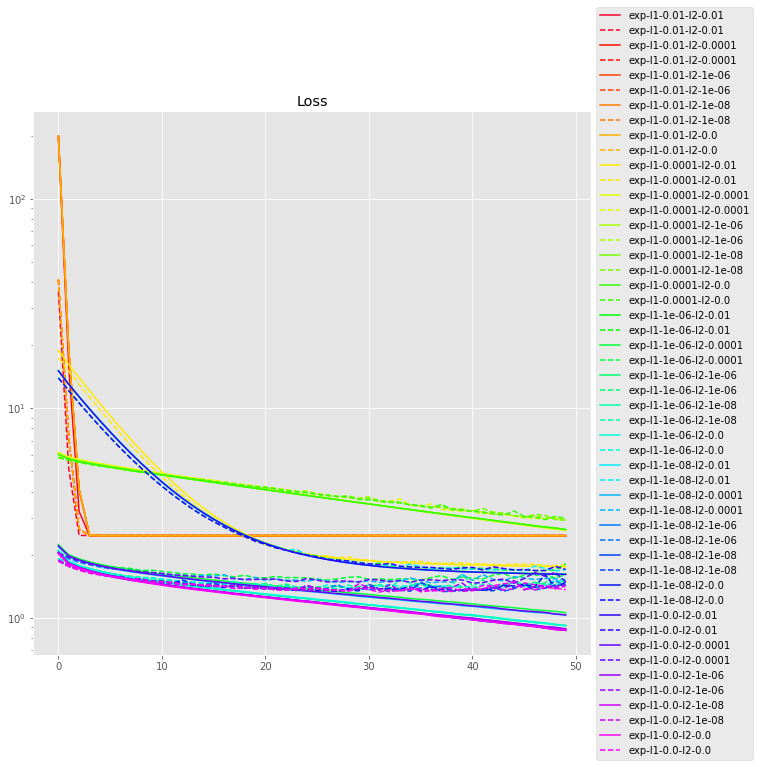

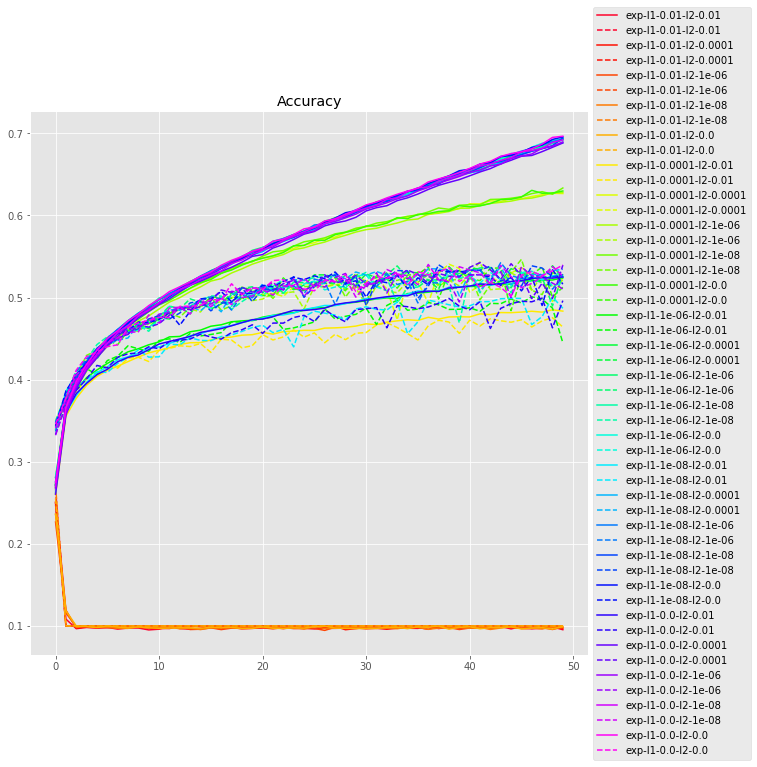

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
"""Code Here
將結果繪出
"""
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
#color_bar = ["r", "g", "b", "c", "y", "m", "k", "w"]

plt.figure(figsize=(10,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(10,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()